In [ ]:
!pip install timm

     |████████████████████████████████| 431 kB 5.3 MB/s 


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import transforms, datasets, models

import timm

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

import albumentations
import PIL
import PIL.Image as Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
set_seed(seed=101)

Random seed 101 has been set.


# Importing Useful Functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# importing helper function
from helper_functions import create_tensorboard_callback, plot_loss_curves, pred_and_plot, unzip_data, walk_through_dir

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

--2022-02-03 14:15:32--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-02-03 14:15:32 (48.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]

--2022-02-03 14:15:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.146.128, 209.85.147.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.146.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104

# Unziping Data and making Datasets

In [ ]:
unzip_data('/content/drive/MyDrive/Datasets/all_food_classes.zip')

In [ ]:
train_dir = '/content/all_food_classes/train'
test_dir = '/content/all_food_classes/test'

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

num_workers = 4

BATCH_SIZE = 64
LEARNING_RATE = 0.0001
valid_size = 0.2

cuda


In [ ]:
normalize = transforms.Normalize(
    [0.485, 0.456, 0.406], 
    [0.229, 0.224, 0.225]
)

train_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.CenterCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAdjustSharpness(sharpness_factor=1.2),
    transforms.RandomAutocontrast(p=0.5),
    transforms.ToTensor(),
    normalize,
])

test_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    normalize,
])

In [ ]:
# choose the training and test datasets
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=num_workers)
valid_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=valid_sampler, num_workers=num_workers)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
classes = train_data.classes

class_len = len(classes)
class_len

101

## Ploting Random Images

In [ ]:
import random
import os

def display_random_images(dataset, n=10, classes=None, seed=None):
  if n > 10:
    n = 10
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10.")

  if seed:
    random.seed(seed)  

  # Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # Setup plot
  plt.figure(figsize=(16, 8), dpi=150)

  # Loop through samples and display
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
    # Min-max scale
    sample_min, sample_max = targ_image.min(), targ_image.max()
    sample_scaled = (targ_image - sample_min)/(sample_max - sample_min)

    # Adjust for shape (colour, height, width) -> (height, width, colour)
    sample_adjust = sample_scaled.permute(1, 2, 0)
    # print(sample_adjust)

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(sample_adjust)
    plt.axis("off")
    if classes:
      plt.title(classes[targ_label])

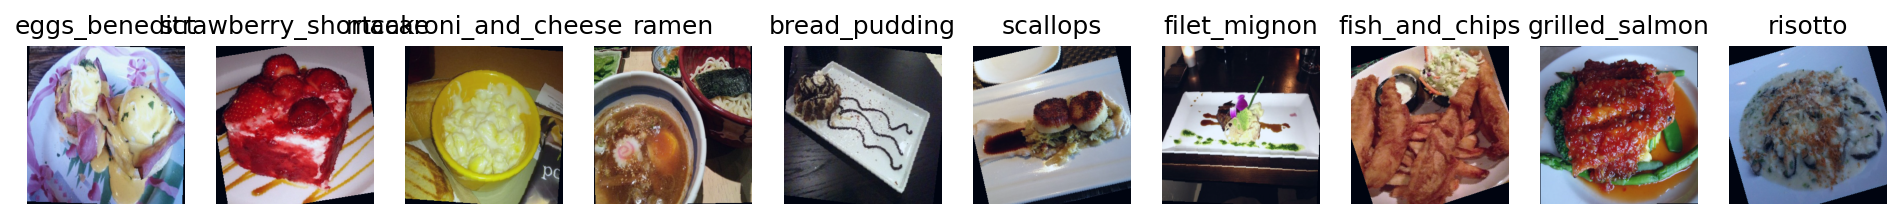

In [ ]:
display_random_images(train_data, n=10, classes=classes)

## Function 

* plotting loss curves

In [ ]:
# code to plot loss and accuracy
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  #plt.show()

# Weights and Biases

In [ ]:
%%capture
!pip install wandb --upgrade

In [ ]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import wandb

wandb.init(project="SeeFood", entity="vishal_rk1")

wandb: Currently logged in as: vishal_rk1 (use `wandb login --relogin` to force relogin)


In [ ]:
config = dict(
    epochs=15,
    classes=101,
    kernels=[16, 32],
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
)

# Creating Model

In [ ]:
class SeeFoodModel(nn.Module):
  def __init__(self, classes, training=False):
    super(SeeFoodModel, self).__init__()

    self.classes = classes

    self.base_model = timm.create_model(pretrained=True, model_name='rexnet_200')
    self.base_model.head.fc = nn.Linear(2560, self.classes)

  def forward(self, x):
    x = self.base_model(x)
    return x

In [ ]:
seeFoodModel = SeeFoodModel(class_len)
seeFoodModel.to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rexnet/rexnetv1_200-8c0b7f2d.pth" to /root/.cache/torch/hub/checkpoints/rexnetv1_200-8c0b7f2d.pth


SeeFoodModel(
  (base_model): ReXNetV1(
    (stem): ConvBnAct(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (act): SiLU(inplace=True)
      )
    )
    (features): Sequential(
      (0): LinearBottleneck(
        (conv_dw): ConvBnAct(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (bn): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (act): Identity()
          )
        )
        (act_dw): ReLU6()
        (conv_pwl): ConvBnAct(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (act): Identity()
          )
        )
      )
      (1): LinearBottleneck(
 

In [ ]:
for param in seeFoodModel.parameters():
    param.requires_grad = True

for param in seeFoodModel.base_model.features[:13].parameters():
    param.requires_grad = False

In [ ]:
!pip install torchinfo

from torchinfo import summary

summary(seeFoodModel, input_size=[1, 3, 299, 299])

Layer (type:depth-idx)                             Output Shape              Param #
SeeFoodModel                                       --                        --
├─ReXNetV1: 1-1                                    [1, 101]                  --
│    └─ConvBnAct: 2-1                              [1, 64, 150, 150]         --
│    │    └─Conv2d: 3-1                            [1, 64, 150, 150]         1,728
│    │    └─BatchNormAct2d: 3-2                    [1, 64, 150, 150]         128
│    └─Sequential: 2-2                             [1, 2560, 10, 10]         --
│    │    └─LinearBottleneck: 3-3                  [1, 32, 150, 150]         (2,816)
│    │    └─LinearBottleneck: 3-4                  [1, 54, 75, 75]           (19,116)
│    │    └─LinearBottleneck: 3-5                  [1, 77, 75, 75]           (46,810)
│    │    └─LinearBottleneck: 3-6                  [1, 100, 38, 38]          (123,668)
│    │    └─LinearBottleneck: 3-7                  [1, 122, 38, 38]          (201,994)


# Training Model

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
epochs = 15

optimizer = optim.Adam(seeFoodModel.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss().to(device)
schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.01, patience=2)

In [ ]:
def train_log(loss, example_ct, epoch):
    # Where the magic happens
    wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
    print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")

In [ ]:
# Model training

results = {
    'train_losses': [],
    'valid_losses': [],
    'train_acc': [],
    'valid_acc': [],
}

prev_valid_loss = 0

# Tell wandb to watch what the model gets up to: gradients, weights, and more!
wandb.watch(seeFoodModel, criterion, log="all", log_freq=10)

batch_ct = 0
example_ct = 0

for epoch in range(epochs):
  print(f'<----- Epoch: {epoch+1} ----->')
  train_loss = 0
  valid_loss = 0

  train_acc = 0
  valid_acc = 0

  # training model on training dataset
  seeFoodModel.train()
  for images, labels in tqdm(train_dataloader, total=len(train_dataloader)):
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()

    output = seeFoodModel(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    example_ct +=  len(images)
    batch_ct += 1

    output_class = torch.softmax(output, dim=1).argmax(dim=1)
    train_acc += (output_class == labels).sum().item()/len(output)

    if ((batch_ct + 1) % 25) == 0:
      train_log(loss, example_ct, epoch)

  # evaluating model on validation dataset
  seeFoodModel.eval()
  for images, labels in tqdm(valid_dataloader, total=len(valid_dataloader)):
    images, labels = images.to(device), labels.to(device)

    output = seeFoodModel(images)
    loss = criterion(output, labels)

    valid_loss += loss.item()

    output_class = torch.softmax(output, dim=1).argmax(dim=1)
    valid_acc += (output_class == labels).sum().item()/len(output)

  # calculating losses
  train_loss = train_loss / len(train_dataloader)
  valid_loss = valid_loss / len(valid_dataloader)

  # calculating accuracy
  train_acc = train_acc / len(train_dataloader)
  valid_acc = valid_acc / len(valid_dataloader)

  wandb.log({"test_accuracy": valid_acc})

  if valid_loss < prev_valid_loss or prev_valid_loss == 0:
    print('Saving Model')
    torch.save(seeFoodModel.state_dict(), '/content/drive/MyDrive/Datasets/SeeFood/seeFoodModel_rexnet_final_2.pt')
    prev_valid_loss = valid_loss

    # Save the model in the exchangeable ONNX format
    torch.onnx.export(seeFoodModel, images, "model.onnx")
    wandb.save("model.onnx")

  # storing losses and accuracy
  results['train_losses'].append(train_loss)
  results['valid_losses'].append(valid_loss)
  results['train_acc'].append(train_acc)
  results['valid_acc'].append(valid_acc)

  schedular.step(valid_loss)

  print('Training Loss: {:.6f} \tTraining Accuracy: {:.2f}'.format(train_loss, train_acc))
  print('Validation Loss: {:.6f} \tValidation Accuracy: {:.2f}'.format(valid_loss, valid_acc))
  print('\n')

<----- Epoch: 1 ----->


  0%|          | 0/947 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


RuntimeError: ignored

# Making Prediction on Image

In [ ]:
model = SeeFoodModel(class_len)
model.load_state_dict(torch.load('/content/drive/MyDrive/Datasets/SeeFood/seeFoodModel_rexnet_2.pt'))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rexnet/rexnetv1_200-8c0b7f2d.pth" to /root/.cache/torch/hub/checkpoints/rexnetv1_200-8c0b7f2d.pth


<All keys matched successfully>

In [ ]:
model.to(device)

SeeFoodModel(
  (base_model): ReXNetV1(
    (stem): ConvBnAct(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (act): SiLU(inplace=True)
      )
    )
    (features): Sequential(
      (0): LinearBottleneck(
        (conv_dw): ConvBnAct(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (bn): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (act): Identity()
          )
        )
        (act_dw): ReLU6()
        (conv_pwl): ConvBnAct(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (act): Identity()
          )
        )
      )
      (1): LinearBottleneck(
 

In [ ]:
# function to calculate accuracy 
def calculate_acc(model, loader):
  n_correct = 0
  n_total = 0

  for inputs, targets in loader:
    # moving data to gpu
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Getting prediction
    # torch max returns both max and argmax
    _, preds = torch.max(outputs, 1)

    # Updating counts
    n_correct += (preds == targets).sum().item()
    n_total += targets.shape[0] 

  acc = n_correct / n_total
  return acc


acc = calculate_acc(seeFoodModel, test_dataloader)
print(acc)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

def model_prediction(model, dataloader):
  """Prediction step."""
  # Set model to eval mode
  model.eval()
  y_trues, y_probs = [], []
  # Iterate over val batches
  for inputs, targets in dataloader:
    # Forward pass w/ inputs
    # batch = [item.to(.device) for item in batch]  # Set device
    inputs, targets = inputs.to(device), targets.to(device)
    z = model(inputs)
    # Store outputs
    y_prob = F.softmax(z, dim=1).detach().cpu().numpy()
    y_probs.extend(y_prob)
  return np.vstack(y_probs)

In [ ]:
y_prob = model_prediction(model, test_dataloader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


RuntimeError: ignored

In [ ]:
img_path = '/content/all_food_classes/test/apple_pie/1011328.jpg'

img = Image.open(img_path)

In [ ]:
img_input = test_transform(img)
img_input = img_input.unsqueeze(dim=0)
img_input.to(device)
img_input.shape

In [ ]:
pred = model(img_input)